In [1]:
#PREPROCESSING

import zipfile
import pandas as pd
import numpy as np
import seaborn as sns

#Unzip data file and read CSV

with zipfile.ZipFile('/content/drive/MyDrive/dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive')
  
df_train = pd.read_csv('../content/drive/MyDrive/training.csv',header=None) 
df_test = pd.read_csv('../content/drive/MyDrive/test.csv',header=None) 

#Filter the data, we only want data with label = 4 or label = 0. Keep only the columns text and label.

df_train = df_train.loc[df_train[0].isin(["4","0"])]
df_train = df_train.iloc[:,[0,5]]
df_train = df_train.rename(columns={0: "label", 5: "text"})
df_train['label'] = df_train['label'].replace(4,1)

df_test = df_test.loc[df_test[0].isin(["4","0"])]
df_test = df_test.iloc[:,[0,5]]
df_test = df_test.rename(columns={0: "label", 5: "text"})
df_test['label'] = df_test['label'].replace(4,1)

print(df_train,df_train.shape,df_test,df_test.shape)



       label                                               text
0          1       I LOVE @Health4UandPets u guys r the best!! 
1          1  im meeting up with one of my besties tonight! ...
2          1  @DaRealSunisaKim Thanks for the Twitter add, S...
3          1  Being sick can be really cheap when it hurts t...
4          1    @LovesBrooklyn2 he has that effect on everyone 
...      ...                                                ...
12995      0  @ZoeAimee I'm trying to research some dude for...
12996      0  just got up, pshhh going on the trampoline, ev...
12997      0                                          Homework 
12998      0  @pmarnandus re: daily gossip.. well the twitte...
12999      0  http://twitpic.com/2y7bg - This is Ashley from...

[13000 rows x 2 columns] (13000, 2)      label                                               text
0        1  @stellargirl I loooooooovvvvvveee my Kindle2. ...
1        1  Reading my kindle2...  Love it... Lee childs i...
2        

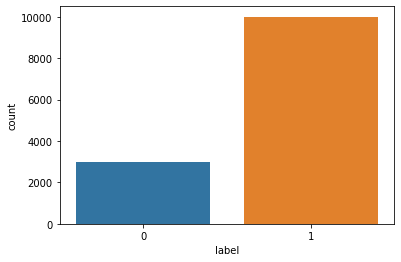

In [2]:
#Train data distribution
sns.countplot(x = 'label', data = df_train)

In [3]:
#CLEAN DATA

import re
import string
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stopword = stopwords.words('english')

#Remove links, usernames, punctuation and stopwords.

def remove_usernames_links(tweet):
    tweet = re.sub('@[^\s]+','',tweet)
    tweet = re.sub('http[^\s]+','',tweet)
    return tweet

def remove_punct(tweet):
    tweet  = "".join([char for char in tweet if char not in string.punctuation])
    tweet = re.sub('[0-9]+', '', tweet)
    return tweet.lower()

def tokenization(text):
    return text.split()

def remove_stopwords(tweet):
    tweet = [word for word in tweet if word not in stopword]
    tweet = [word for word in tweet if len(word) > 2]
    return tweet      

df_train["text"]= df_train["text"].apply(remove_usernames_links)
df_train["text_clean"] = df_train["text"].apply(remove_punct)
df_train['text_token'] = df_train['text_clean'].apply(tokenization)
df_train['text_token'] = df_train['text_token'].apply(remove_stopwords)


df_test["text"]= df_test["text"].apply(remove_usernames_links)
df_test["text_clean"] = df_test["text"].apply(remove_punct)
df_test['text_token'] = df_test['text_clean'].apply(tokenization)
df_test['text_token'] = df_test['text_token'].apply(remove_stopwords)

df_train.head(-30)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,label,text,text_clean,text_token
0,1,I LOVE u guys r the best!!,i love u guys r the best,"[love, guys, best]"
1,1,im meeting up with one of my besties tonight! ...,im meeting up with one of my besties tonight c...,"[meeting, one, besties, tonight, cant, wait, g..."
2,1,"Thanks for the Twitter add, Sunisa! I got to ...",thanks for the twitter add sunisa i got to me...,"[thanks, twitter, add, sunisa, got, meet, hin,..."
3,1,Being sick can be really cheap when it hurts t...,being sick can be really cheap when it hurts t...,"[sick, really, cheap, hurts, much, eat, real, ..."
4,1,he has that effect on everyone,he has that effect on everyone,"[effect, everyone]"
...,...,...,...,...
12965,0,except for the fact JW stuff is out and it roc...,except for the fact jw stuff is out and it roc...,"[except, fact, stuff, rocks, shame, skint]"
12966,0,omg i know i am so sad,omg i know i am so sad,"[omg, know, sad]"
12967,0,Ternyata hanya gue yang make twitter ....,ternyata hanya gue yang make twitter,"[ternyata, hanya, gue, yang, make, twitter]"
12968,0,Being in pain as I have done my back in,being in pain as i have done my back in,"[pain, done, back]"


In [4]:
#Create TF-IDF and LSI for test and train

import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline


def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False)    
svd= TruncatedSVD(n_components=250)

svd_transformer = Pipeline([('tfidf', tfidf), ('svd', svd)])

lsi_train = svd_transformer.fit_transform(df_train['text_token'])
lsi_test = svd_transformer.transform(df_test['text_token'])

print(lsi_train.shape,lsi_test.shape,lsi_train)


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  % sorted(inconsistent)


(13000, 250) (359, 250) [[ 0.05479788  0.0531655  -0.12511916 ... -0.00457613  0.00519446
   0.00240129]
 [ 0.02524835  0.02015696 -0.04036638 ...  0.02483336  0.03195109
  -0.02646464]
 [ 0.05101708  0.20990617  0.01699866 ... -0.0120708   0.01086896
   0.01233824]
 ...
 [ 0.00238334  0.00159197 -0.00712216 ... -0.00083462 -0.00762151
   0.00041781]
 [ 0.01760613  0.01498671 -0.03401578 ... -0.00463273 -0.04079899
   0.02455434]
 [ 0.02198578  0.01475816 -0.03460582 ...  0.02439692  0.02125801
   0.00235206]]


In [5]:
#Feed LSI into SVM Classifier

from sklearn.svm import SVC
y_train = df_train["label"]
y_test = df_test["label"]


svm = SVC(kernel='linear',class_weight = "balanced")
svm.fit(lsi_train, y_train).score(lsi_train, y_train)
pred = svm.predict(lsi_test)


In [6]:
#Metrics
#F1-score(combination of precision and recall) and confusion matrix

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

print(f1_score(y_test, pred))
confusion_matrix(y_test, pred)

0.7535545023696681


array([[ 96,  81],
       [ 23, 159]])

In [7]:
#Visualization of predicted labels vs true labels

predictionsdf = {'text': df_test['text'],
        'prediction': pred,
        'true_label': y_test
       }
df_pred = pd.DataFrame(predictionsdf)

df_pred.head(300)

,text,prediction,true_label
0,I loooooooovvvvvveee my Kindle2. Not that the...,1,1
1,Reading my kindle2... Love it... Lee childs i...,1,1
2,"Ok, first assesment of the #kindle2 ...it fuck...",0,1
3,You'll love your Kindle2. I've had mine for a...,1,1
4,Fair enough. But i have the Kindle2 and I th...,1,1
...,...,...,...
388,Cox or Time Warner? Cox is cheaper and gets a...,1,0
389,i am furious with time warner and their phone ...,0,0
390,Just got home from chick-fil-a with the boys. ...,0,0
391,could time-warner cable suck more? NO.,0,0


In [8]:
#SAVE MODELS:
import pickle 

pickle.dump(tfidf.vocabulary_,open("tfdif.pkl","wb"))
pickle.dump(svm, open('svm.sav', 'wb'))
